In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from traffic.core import Traffic
training_trajectories_path = "../data/real/OpenSky_EHAM_LIMC.pkl"
training_trajectories = Traffic.from_file(training_trajectories_path)
synthetic_trajectories_path = "../data/synthetic_compare/OpenSky_EHAM_LIMC.pkl"
synthetic_trajectories = Traffic.from_file(synthetic_trajectories_path)
route_name = "EHAM_LIMC"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyproj import Geod
sns.set(style="whitegrid")

def get_flight_durations(traffic):
    durations = []
    for flight in traffic:
        duration = (flight.data['timestamp'].max() - flight.data['timestamp'].min()).total_seconds() / 60  # in minutes
        durations.append(duration)
    return np.array(durations)

def get_flight_speeds(traffic, method='calculate', remove_outliers=True, lower_quantile=0.01, upper_quantile=0.99):
    all_speeds = []
    geod = Geod(ellps="WGS84")
    
    for flight in traffic:
        if method == 'groundspeed' and 'groundspeed' in flight.data.columns:
            speeds = flight.data['groundspeed'].values
        elif method == 'calculate':
            coords = np.column_stack((flight.data['longitude'], flight.data['latitude']))
            times = flight.data['timestamp'].values
            
            distances = geod.inv(coords[:-1, 0], coords[:-1, 1], coords[1:, 0], coords[1:, 1])[2]
            time_diffs = np.diff(times).astype('timedelta64[s]').astype(float)
            
            # Filter out invalid or negative time differences
            valid_mask = (time_diffs > 0) & (distances >= 0)
            valid_distances = distances[valid_mask]
            valid_time_diffs = time_diffs[valid_mask]
            
            # Calculate speeds and convert to km/h
            speeds = valid_distances / valid_time_diffs * 3.6  
        else:
            raise ValueError("Method must be either 'groundspeed' or 'calculate'")
        
        # Remove zero speeds
        speeds = speeds[speeds > 0]
        
        all_speeds.extend(speeds)
    
    all_speeds = np.array(all_speeds)
    if remove_outliers:
        lower_bound = np.quantile(all_speeds, lower_quantile)
        upper_bound = np.quantile(all_speeds, upper_quantile)
        all_speeds = all_speeds[(all_speeds >= lower_bound) & (all_speeds <= upper_bound)]
    
    return all_speeds

training_durations = get_flight_durations(training_trajectories)
synthetic_durations = get_flight_durations(synthetic_trajectories)

small_training_trajectories = training_trajectories[:2000]
small_synthetic_trajectories = synthetic_trajectories[:2000]

training_speeds = get_flight_speeds(small_training_trajectories, method='calculate')
synthetic_speeds = get_flight_speeds(small_synthetic_trajectories, method='calculate')


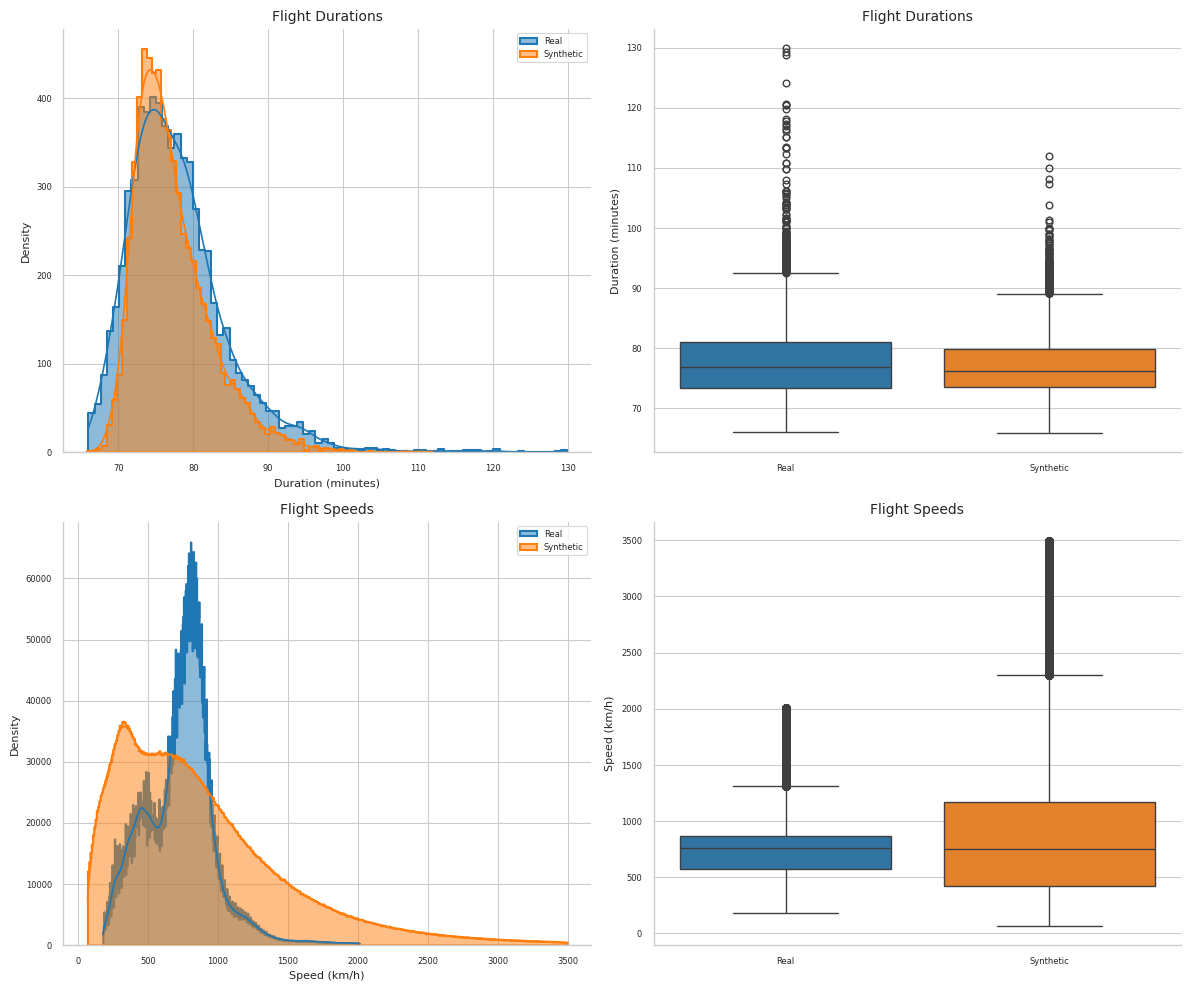

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress specific UserWarnings related to set_xticklabels
warnings.filterwarnings("ignore", message=".*set_ticklabels.*")

# Set the style for a more professional look
sns.set_style("whitegrid")
sns.set_context("paper")

# Create a single figure with two rows and two columns
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Row 1: Flight Durations
sns.histplot(training_durations, kde=True, element="step", label='Real', color='#1f77b4', linewidth=1.5, ax=axes[0, 0])
sns.histplot(synthetic_durations, kde=True, element="step", label='Synthetic', color='#ff7f0e', linewidth=1.5, ax=axes[0, 0])
axes[0, 0].set_title('Flight Durations', fontsize=10)
axes[0, 0].set_xlabel('Duration (minutes)', fontsize=8)
axes[0, 0].set_ylabel('Density', fontsize=8)
axes[0, 0].legend(fontsize=6)
axes[0, 0].tick_params(labelsize=6)

sns.boxplot(data=[training_durations, synthetic_durations], palette=['#1f77b4', '#ff7f0e'], ax=axes[0, 1])
axes[0, 1].set_xticklabels(['Real', 'Synthetic'], fontsize=8)
axes[0, 1].set_title('Flight Durations', fontsize=10)
axes[0, 1].set_ylabel('Duration (minutes)', fontsize=8)
axes[0, 1].tick_params(labelsize=6)

# Row 2: Flight Speeds
sns.histplot(training_speeds, kde=True, element="step", label='Real', color='#1f77b4', linewidth=1.5, ax=axes[1, 0])
sns.histplot(synthetic_speeds, kde=True, element="step", label='Synthetic', color='#ff7f0e', linewidth=1.5, ax=axes[1, 0])
axes[1, 0].set_title('Flight Speeds', fontsize=10)
axes[1, 0].set_xlabel('Speed (km/h)', fontsize=8)
axes[1, 0].set_ylabel('Density', fontsize=8)
axes[1, 0].legend(fontsize=6)
axes[1, 0].tick_params(labelsize=6)

sns.boxplot(data=[training_speeds, synthetic_speeds], palette=['#1f77b4', '#ff7f0e'], ax=axes[1, 1])
axes[1, 1].set_xticklabels(['Real', 'Synthetic'], fontsize=8)
axes[1, 1].set_title('Flight Speeds', fontsize=10)
axes[1, 1].set_ylabel('Speed (km/h)', fontsize=8)
axes[1, 1].tick_params(labelsize=6)

# Adjust layout and remove top and right spines
plt.tight_layout()
for ax in axes.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Add a main title for the entire figure
# fig.suptitle('Comparison of Real and Synthetic Flight Data', fontsize=12, y=1.02)

# Save the figure
plt.savefig(f"../.figures/distribution_plots_{route_name}.png", bbox_inches='tight')
plt.show()